In [17]:
import uproot3 as uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
date = datetime.today().strftime('%Y%m%d')

def loadSingleFile( tfile, treename, flatenndf=False ):
    ttree = uproot.open(tfile)
    data = ttree[treename].arrays(outputtype=pd.DataFrame,flatten=flatenndf)
    return data

def loadFiles( filelist, treename1, treename2, maxfiles=100, flatenndf=False):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for i,tfile in enumerate(filelist[0:maxfiles]):
        if i%10 == 0:
            print("{} files processed".format(i))
        ttree = uproot.open(tfile)
        data1 = pd.concat([data1, ttree[treename1].arrays(outputtype=pd.DataFrame,flatten=flatenndf)])
        data2 = pd.concat([data2, ttree[treename2].arrays(outputtype=pd.DataFrame,flatten=flatenndf)])
    return data1, data2

## Prepare data files

In [22]:
### PREPARE DATA ####
RUN = "8461"
MATCHES = "../output/run{}_matched_light_tracks.txt".format(RUN)
LIGHTINFO = "../inputs/run{}_tracks_BNBMAJORITY_files.txt".format(RUN)
FILENAMES = [ line.strip() for line in open(LIGHTINFO, "r") ]

#maxim = 1
maxim = len(FILENAMES)
#print(maxim)

### CASE 1: New (complete) light trees 

In [23]:
## Get the light data and combine the two cryostats
dfopw, dfope = loadFiles(FILENAMES, "simpleLightAna/opflashCryoW_ophittree", "simpleLightAna/opflashCryoE_ophittree", maxim)
dfopw["cryo"] = 1
dfope["cryo"] = 0
df = pd.concat([dfope, dfopw])
del dfopw
del dfope

0 files processed
10 files processed
20 files processed
30 files processed
40 files processed
50 files processed
60 files processed
70 files processed
80 files processed
90 files processed
100 files processed
110 files processed
120 files processed
130 files processed
140 files processed
150 files processed
160 files processed
170 files processed
180 files processed
190 files processed
200 files processed
210 files processed
220 files processed
230 files processed
240 files processed
250 files processed
260 files processed
270 files processed


In [24]:
geo = loadSingleFile(FILENAMES[0], "simpleLightAna/geotree")
x = geo.pmt_x.values[0] ; y = geo.pmt_y.values[0] ; z = geo.pmt_z.values[0]
df["pmt_x"] = [ x[ch] for ch in df.channel_id.values ] 
df["pmt_y"] = [ y[ch] for ch in df.channel_id.values ] 
df["pmt_z"] = [ z[ch] for ch in df.channel_id.values ]

del geo

In [25]:
## Now match with the selected tracks
dfmatches = pd.read_csv(MATCHES)
dfmatches.rename(columns={'flashID':"flash_id"}, inplace=True)
dfmatches.set_index(["run", "event", "cryo", "flash_id"], inplace=True)
df = (df.join( dfmatches, on=["run", "event", "cryo", "flash_id"], how='inner'))

print("Consider {} tracks".format( len(df) ) )

Consider 2661554 tracks


In [26]:
df.head()

,run,event,timestamp,flash_id,channel_id,integral,amplitude,start_time,abs_start_time,pe,...,trackStartX,trackStartY,trackStartZ,trackEndX,trackEndY,trackEndZ,trackDirX,trackDirY,trackDirZ,trackLenght
entry,,,,,,,,,,,,,,,,,,,,,
4278,8461,63617,1654814122,3,170,816.000000,55.200001,221.179764,1721.179810,2.563974,...,-164.536,134.301,673.438,-319.761,-178.392,496.005,-0.311158,-0.856341,-0.412141,391.605
4279,8461,63617,1654814122,3,173,1436.400024,95.599998,221.165833,1721.165894,4.513348,...,-164.536,134.301,673.438,-319.761,-178.392,496.005,-0.311158,-0.856341,-0.412141,391.605
4280,8461,63617,1654814122,3,85,883.200012,60.200001,221.172119,1721.172119,2.775124,...,-164.536,134.301,673.438,-319.761,-178.392,496.005,-0.311158,-0.856341,-0.412141,391.605
4281,8461,63617,1654814122,3,64,2639.600098,135.399994,221.169373,1721.169312,8.293952,...,-164.536,134.301,673.438,-319.761,-178.392,496.005,-0.311158,-0.856341,-0.412141,391.605
4282,8461,63617,1654814122,3,60,507.000000,82.000000,221.167358,1721.167358,1.593057,...,-164.536,134.301,673.438,-319.761,-178.392,496.005,-0.311158,-0.856341,-0.412141,391.605


In [27]:
events = np.unique(df.event.values)
len(events)

7352

## Check amplitude vs quota

In [28]:
_sel = df.pe>300

In [29]:
df = df[_sel].groupby(["pmt_y"]).agg(list).reset_index()
df["avg_amp"] = df.amplitude.apply( lambda x: np.mean(x) )
df["std_amp"] = df.amplitude.apply( lambda x: np.std(x) )
df["med_amp"] = df.amplitude.apply( lambda x: np.median(x) )
df["max_amp"] = df.amplitude.apply( lambda x: np.max(x) )
df.head()

,pmt_y,run,event,timestamp,flash_id,channel_id,integral,amplitude,start_time,abs_start_time,...,trackEndY,trackEndZ,trackDirX,trackDirY,trackDirZ,trackLenght,avg_amp,std_amp,med_amp,max_amp
0,-129.050003,"[8461, 8461, 8461, 8461, 8461, 8461, 8461, 846...","[63617, 63617, 63617, 63797, 63797, 63797, 637...","[1654814122, 1654814122, 1654814122, 165481441...","[3, 3, 3, 4, 4, 4, 4, 2, 2, 1, 1, 1, 5, 1, 1, ...","[65, 75, 72, 165, 162, 82, 75, 102, 12, 112, 1...","[121674.6015625, 204720.0, 465916.59375, 13121...","[2492.800048828125, 3564.39990234375, 8403.200...","[220.22991943359375, 220.21559143066406, 220.2...","[1720.2298583984375, 1720.215576171875, 1720.2...",...,"[-178.392, -178.392, -178.392, -177.215, -177....","[496.005, 496.005, 496.005, 535.213, 535.213, ...","[-0.311158, -0.311158, -0.311158, 0.254481, 0....","[-0.856341, -0.856341, -0.856341, -0.733355, -...","[-0.412141, -0.412141, -0.412141, -0.630421, -...","[391.605, 391.605, 391.605, 450.14, 450.14, 45...",3620.981676,2409.127886,2788.600098,15220.599609
1,-76.250000,"[8461, 8461, 8461, 8461, 8461, 8461, 8461, 846...","[63617, 63617, 63617, 63797, 63797, 63797, 640...","[1654814122, 1654814122, 1654814122, 165481441...","[3, 3, 3, 4, 4, 4, 2, 1, 1, 1, 5, 1, 1, 1, 1, ...","[78, 70, 68, 168, 160, 78, 100, 110, 108, 100,...","[140437.796875, 344854.59375, 287066.65625, 16...","[2586.800048828125, 6573.2001953125, 5862.9995...","[220.21734619140625, 220.2157745361328, 220.21...","[1720.21728515625, 1720.2158203125, 1720.21398...",...,"[-178.392, -178.392, -178.392, -177.215, -177....","[496.005, 496.005, 496.005, 535.213, 535.213, ...","[-0.311158, -0.311158, -0.311158, 0.254481, 0....","[-0.856341, -0.856341, -0.856341, -0.733355, -...","[-0.412141, -0.412141, -0.412141, -0.630421, -...","[391.605, 391.605, 391.605, 450.14, 450.14, 45...",3606.022434,2384.570820,2782.399902,15236.200195
2,-23.450001,"[8461, 8461, 8461, 8461, 8461, 8461, 8461, 846...","[63617, 63617, 63617, 63797, 63797, 63797, 637...","[1654814122, 1654814122, 1654814122, 165481441...","[3, 3, 3, 4, 4, 4, 4, 4, 2, 2, 2, 1, 1, 1, 5, ...","[166, 73, 76, 163, 73, 86, 83, 76, 16, 13, 6, ...","[101119.0, 389826.0, 358165.0, 117578.0, 11378...","[1583.5999755859375, 6420.0, 6279.0, 2039.5999...","[220.21583557128906, 220.21412658691406, 220.2...","[1720.2158203125, 1720.214111328125, 1720.2106...",...,"[-178.392, -178.392, -178.392, -177.215, -177....","[496.005, 496.005, 496.005, 535.213, 535.213, ...","[-0.311158, -0.311158, -0.311158, 0.254481, 0....","[-0.856341, -0.856341, -0.856341, -0.733355, -...","[-0.412141, -0.412141, -0.412141, -0.630421, -...","[391.605, 391.605, 391.605, 450.14, 450.14, 45...",2829.161840,1303.873140,2471.800049,15224.000000
3,29.350000,"[8461, 8461, 8461, 8461, 8461, 8461, 8461, 846...","[63617, 63617, 63617, 63617, 63797, 63797, 637...","[1654814122, 1654814122, 1654814122, 165481412...","[3, 3, 3, 3, 4, 4, 4, 2, 2, 1, 1, 1, 5, 1, 1, ...","[81, 79, 69, 169, 89, 81, 79, 9, 11, 111, 109,...","[99677.6015625, 174785.40625, 133423.796875, 1...","[1403.199951171875, 2603.800048828125, 2151.39...","[220.21702575683594, 220.21530151367188, 220.2...","[1720.217041015625, 1720.21533203125, 1720.215...",...,"[-178.392, -178.392, -178.392, -178.392, -177....","[496.005, 496.005, 496.005, 496.005, 535.213, ...","[-0.311158, -0.311158, -0.311158, -0.311158, 0...","[-0.856341, -0.856341, -0.856341, -0.856341, -...","[-0.412141, -0.412141, -0.412141, -0.412141, -...","[391.605, 391.605, 391.605, 391.605, 450.14, 4...",2982.925671,1662.692296,2461.299927,15205.599609
4,82.150002,"[8461, 8461, 8461, 8461, 8461, 8461, 8461, 846...","[63617, 63617, 63617, 63617, 63797, 63797, 637...","[1654814122, 1654814122, 1654814122, 165481412...","[3, 3, 3, 3, 4, 4, 4, 2, 2, 1, 1, 5, 5, 1, 1, ...","[164, 77, 74, 167, 84, 77, 87, 14, 7, 27, 24, ...","[102924.796875, 165476.203125, 152052.0, 13590...","[1891.4000244140625, 2321.39990234375, 2746.0,...","[220.2144775390625, 220.2159423828125, 220.216...

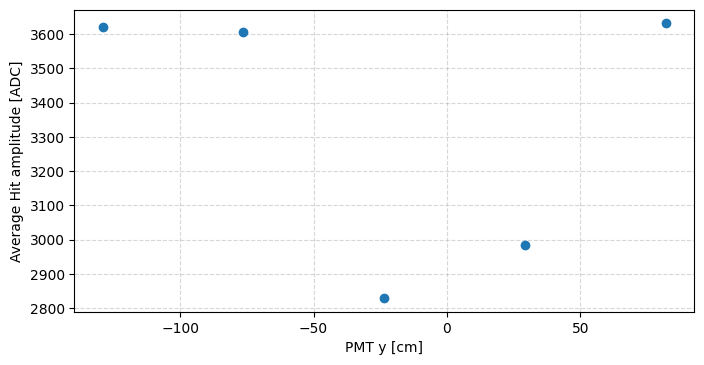

In [30]:
fig = plt.figure(figsize=(8,4),dpi=100)
plt.errorbar(x=df.pmt_y, y=df.avg_amp, yerr=0, fmt='o')
plt.ylabel("Average Hit amplitude [ADC]")
plt.xlabel("PMT y [cm]")
plt.grid(alpha=0.5,linestyle="dashed")
plt.show()

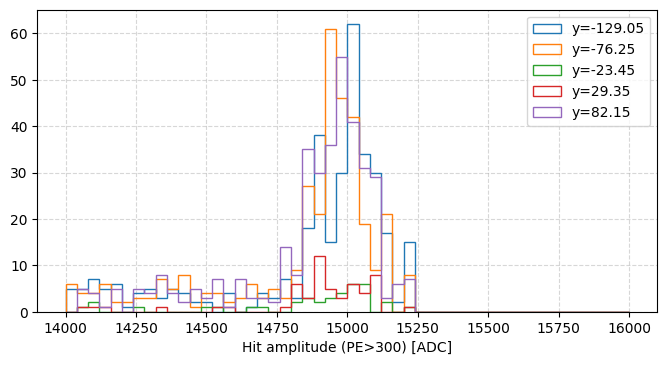

In [43]:
y = df["pmt_y"].to_numpy()
fig = plt.figure(figsize=(8,4),dpi=100)

for iy in y:
    
    plt.hist(df[df.pmt_y==iy].amplitude.values, histtype="step", bins=50, range=(14000,16000),label="y={:.2f}".format(iy))

plt.xlabel("Hit amplitude (PE>{}) [ADC]".format(300))
plt.legend()
plt.grid(alpha=0.5,linestyle="dashed")
plt.savefig("hit_amp_pe300_sat")
plt.show()

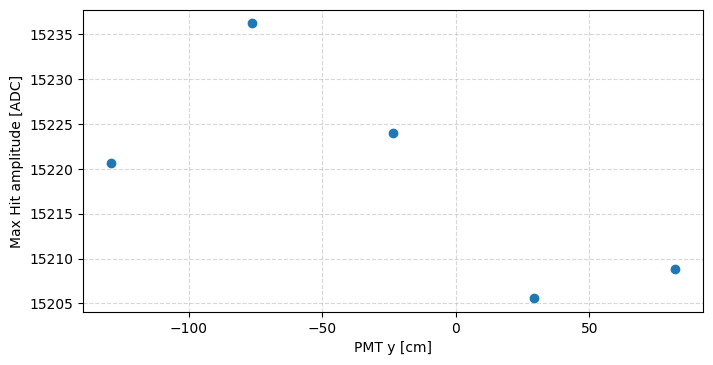

In [39]:
fig = plt.figure(figsize=(8,4),dpi=100)
plt.scatter(x=df.pmt_y, y=df.max_amp)
plt.ylabel("Max Hit amplitude [ADC]")
plt.xlabel("PMT y [cm]")
plt.grid(alpha=0.5,linestyle="dashed")
plt.show()

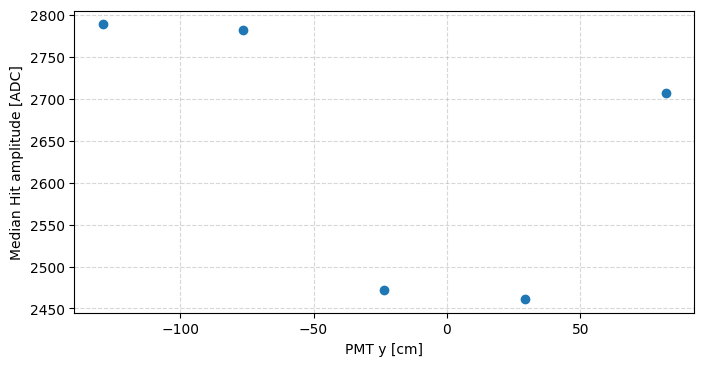

In [40]:
fig = plt.figure(figsize=(8,4),dpi=100)
plt.scatter(x=df.pmt_y, y=df.med_amp)
plt.ylabel("Median Hit amplitude [ADC]")
plt.xlabel("PMT y [cm]")
plt.grid(alpha=0.5,linestyle="dashed")
plt.show()